In [222]:
import tensorflow as tf
import numpy as np
import os
import json

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from preprocess import *

In [223]:
DATA_IN_PATH = '/Users/jeon-yewon/Desktop/데이터 분석 강의/부트캠프/12주차/data_in/'
DATA_OUT_PATH = '/Users/jeon-yewon/Desktop/데이터 분석 강의/부트캠프/12주차/data_out/'
train_inputs = 'train_inputs.npy'
train_outputs = 'train_outputs.npy'
train_targets = 'train_targets.npy'
data_configs = 'data_configs.json'

In [224]:
tf.random.set_seed(42)

In [225]:
index_inputs = np.load(open(DATA_IN_PATH + train_inputs, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + train_outputs, 'rb'))
index_targets = np.load(open(DATA_IN_PATH + train_targets, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + data_configs, 'r'))

In [226]:
print(len(index_inputs), len(index_outputs), len(index_targets))

20 20 20


In [227]:
MODEL_NAME = 'seq2seq_kor'
BATCH_SIZE = 2
MAX_SEQUENCE = 25
EPOCH = 30
UNITS = 1024
EMBEDDING_DIM = 256
VALIDATION_SPLIT = 0.1

char2idx = prepro_configs['char2idx']
idx2char = prepro_configs['idx2char']
std_index = prepro_configs['sos_symbol']
end_index = prepro_configs['end_symbol']
vocab_size = prepro_configs['vocab_size']

In [228]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.enc_units = enc_units
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        # glorot_uniform(Xavier) : 가중치를 무작위로 초기화
        self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self, inp):
        return tf.zeros((tf.shape(inp)[0], self.enc_units))

In [229]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
        super(Decoder, self).__init__()

        self.batch_size = batch_size
        self.dec_units = dec_units
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(self.vocab_size)
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)

        x = self.embedding(x)

        # 컨텍스트 벡터와 임베딩 벡터(디코더 입력)를 결합
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, state = self.gru(x)
        
        output = tf.reshape(output, (-1, output.shape[2]))

        x = self.fc(output)

        return x, state, attention_weights

In [230]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    # call 메서드 context vector와 attention score를 계산한다.
    def call(self, query, values): # query : 디코더의 hidden state, values : 인코더의 출력
        hidden_with_time_axis = tf.expand_dims(query, 1) # hidden state 사이즈 확장
        
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis))) # 점수 계산

        attention_weights = tf.nn.softmax(score, axis=1) # soft max로 가중치 계산

        context_vector = attention_weights * values # 컨텍스트 벡터를 구하기 위해 가중치와 인코더의 출력을 곱한다.
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights 

In [231]:
class seq2seq(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, dec_units, batch_size, end_token_idx = 2):
        super(seq2seq, self).__init__()
        self.end_token_idx = end_token_idx
        self.encoder = Encoder(vocab_size, embedding_dim, enc_units, batch_size)
        self.decoder = Decoder(vocab_size, embedding_dim, dec_units, batch_size)

    def call(self, x): # x 내에 input과 target이 이미 들어가 있어서
        input, target = x # 그냥 하나씩 분리해준 것

        enc_hidden = self.encoder.initialize_hidden_state(input) # 인코드에 hidden 상태(초기화해주는 기능)
        enc_output, enc_hidden = self.encoder(input, enc_hidden) # enc_hidden 활용, input과 enc_hidden을 활용하여 output과 hidden 출력

        dec_hidden = enc_hidden # enc_hidden 상태를 dec_hidden으로 명명(이후 코드 작성 시 헷갈릴 수 있기 때문에)

        predict_tokens = list() # list 제작

        for t in range(0, target.shape[1]): # 디코더 작업
            # expand_dims([1, 2, 3], axis=0 : [[1, 2, 3]], expand_dims([1, 2, 3], axis=1) : [[1], [2], [3]]
            dec_input = tf.dtypes.cast(tf.expand_dims(target[:, t], 1), tf.float32)
            # expand_dims : 차원 확장 -> 디코더 입력 2D 텐서
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output) 
            # decoder input, hidden, output 통해 decoder 처리 -> 기본 출력(predictions(예측)), hidden 등에 저장
            # dtypes.cast : 자료형 변환 -> 모델의 입력과 출력은 동일한 데이터 유형
            predict_tokens.append(tf.dtypes.cast(predictions, tf.float32)) # 계산된 값을 위에 생성한 list에 추가

        return tf.stack(predict_tokens, axis=1) # 형변환 후 반환(call 부분의 최종 반환점)

    def inference(self, x): # 문장 생성 함수(이후 나오는 내용은 따로 안적어두어도 상관없다.)
        input = x # 기본적으로 입력을 받아 처리해준다.

        # call 부분과 구조가 비슷하다.
        enc_hidden = self.encoder.initialize_hidden_state(input) # 초기 히든 상태
        enc_output, enc_hidden = self.encoder(input, enc_hidden) # output과 hidden

        dec_hidden = enc_hidden # 명명
        dec_input = tf.expand_dims([char2idx[std_index]], 1) # 시작 토큰을 이용하여 디코더의 첫 번째 입력을 생성한다.

        predict_tokens = list() 
        for t in range(0, MAX_SEQUENCE): # 문장 최대 길이만큼 반복
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output) # 예측 처리
            predict_token = tf.argmax(predictions[0])

            if predict_token == self.end_token_idx:
                break

            predict_tokens.append(predict_token)
            dec_input = tf.dtypes.cast(tf.expand_dims([predict_token], 0), tf.float32)

        return tf.stack(predict_tokens, axis=0).numpy() # 연결해서 반환

In [232]:
optimizer = tf.keras.optimizers.Adam() # adam 알고리즘

# from_Logits = True : 출력을 Logit값으로 설정, reduction='none' : 손실값 그대로 반환
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') # SparseCategoricalCrossentropy
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy') # 정확도 SparseCateegoricalCrossentropy

# 실제 값 real과 예측 값 pred으로 손실 값을 계산
def loss(real, pred):
    # 마스크 처리 : 실제 값이 0이 아닌 부분만 마스크 처리(패딩된 부분 손실을 제외)
    mask = tf.math.logical_not(tf.math.equal(real, 0))

    # 위에서 제작한 손실함수(loss_object)를 적용
    loss_ = loss_object(real, pred)

    # 마스크를 손실 함수의 데이터 타입으로 변환
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask # 패딩된 부분의 손실을 제외(마스크 적용)
    
    return tf.reduce_mean(loss_) # 평균 손실값 반환

# 실제 값 real과 예측 값 pred으로 정확도를 계산
def accuracy(real, pred): 
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask # 예측값에 먼저 mask를 적용하여 패딩 부분을 제외
    
    acc = train_accuracy(real, pred) # 정확도 함수(train_accuracy) 적용

    return tf.reduce_mean(acc) # 평균 정확도 반환

In [233]:
model = seq2seq(vocab_size, EMBEDDING_DIM, UNITS, UNITS, BATCH_SIZE, char2idx[end_index])
model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(1e-3), metrics=[accuracy])

In [234]:
PATH = DATA_OUT_PATH + MODEL_NAME

if not(os.path.isdir(PATH)):
    os.makedirs(os.path.join(PATH))

checkpoint_path = DATA_OUT_PATH + MODEL_NAME + '.weights.h5'

mc = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.0001, patience=10)

history = model.fit([index_inputs, index_outputs], index_targets, batch_size=BATCH_SIZE, epochs=EPOCH,
                    validation_split=VALIDATION_SPLIT, callbacks=[mc, es])

Epoch 1/30
9/9 [==============================] - ETA: 0s - loss: 0.8350 - accuracy: 0.8506
Epoch 1: val_accuracy improved from -inf to 0.85400, saving model to /Users/jeon-yewon/Desktop/데이터 분석 강의/부트캠프/12주차/data_out/seq2seq_kor.weights.h5
9/9 [==============================] - 44s 2s/step - loss: 0.8350 - accuracy: 0.8506 - val_loss: 0.6874 - val_accuracy: 0.8540
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 0.7380 - accuracy: 0.8544
Epoch 2: val_accuracy improved from 0.85400 to 0.85600, saving model to /Users/jeon-yewon/Desktop/데이터 분석 강의/부트캠프/12주차/data_out/seq2seq_kor.weights.h5
9/9 [==============================] - 16s 2s/step - loss: 0.7380 - accuracy: 0.8544 - val_loss: 0.5797 - val_accuracy: 0.8560
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 0.6638 - accuracy: 0.8555
Epoch 3: val_accuracy improved from 0.85600 to 0.85667, saving model to /Users/jeon-yewon/Desktop/데이터 분석 강의/부트캠프/12주차/data_out/seq2seq_kor.weights.h5
9/9 [==================

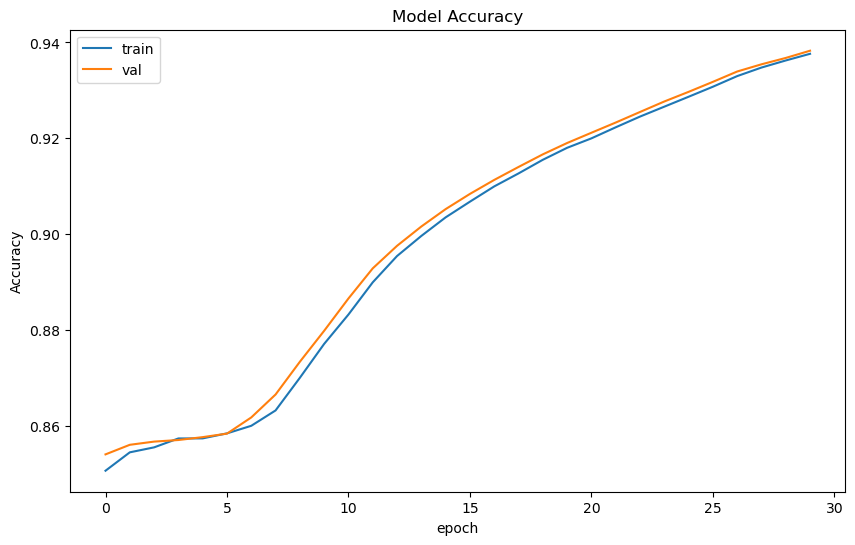

In [235]:
# 정확도 그래프
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])
plt.show()

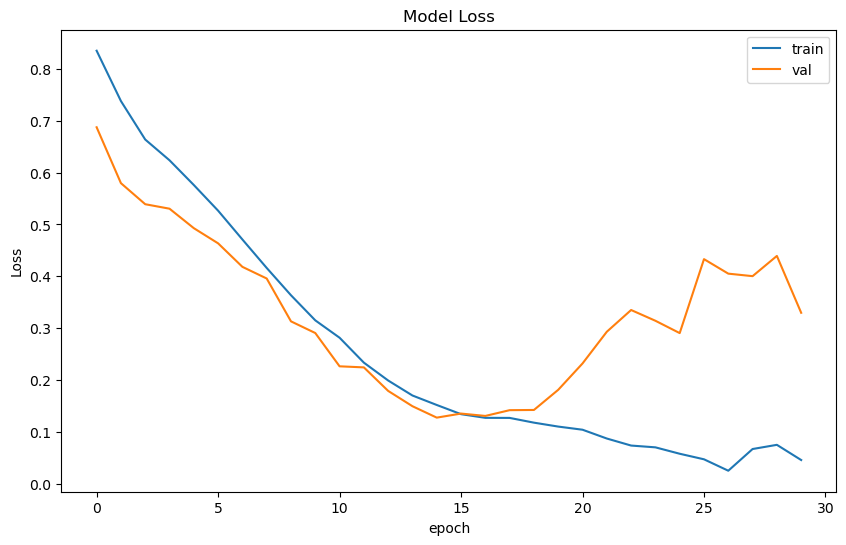

In [236]:
# 손실 그래프
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

In [237]:
# 또는
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

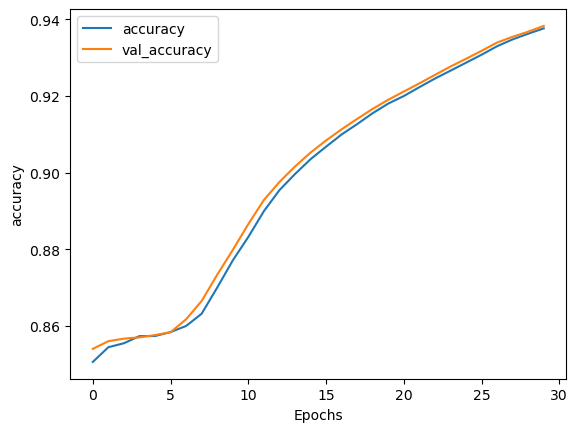

In [238]:
plot_graphs(history, 'accuracy')

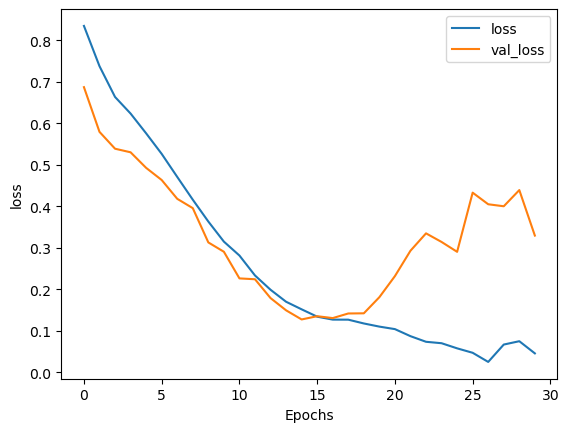

In [239]:
plot_graphs(history, 'loss')

In [240]:
SAVE_FILE = MODEL_NAME + '.weights.h5'
model.load_weights(os.path.join(DATA_OUT_PATH, SAVE_FILE))

In [241]:
FILTERS = "([~.,!?\"':;)(])"
CHANGE_FILTER = re.compile(FILTERS)

PAD = '<PAD>'

PAD_INDEX = 0

In [242]:
def enc_processing(value, dictionary, tokenize_as_morph=False):
    sequences_input_index = []  # 인덱스 저장 딕셔너리
    sequences_length = []  # 길이 저장 딕셔너리

    # 형태소 토크나이징
    if tokenize_as_morph:
        value = prepro_like_morphlized(value)

    # 한 줄씩 처리
    for sequence in value:
        # 정규화
        sequence = re.sub(CHANGE_FILTER, '', sequence)
        sequence_index = []  # 토큰을 저장해둘 배열(한 줄씩)(해당 줄을 저장할 리스트)

        for word in sequence.split():
            if dictionary.get(word) is not None:
                sequence_index.extend([dictionary[word]])  # 존재 o(딕셔너리 index 추가)
            else:
                sequence_index.extend([dictionary[UNK]])  # 존재 x(UNK 토큰 추가)

        if len(sequence_index) > MAX_SEQUENCE:
            sequence_index = sequence_index[:MAX_SEQUENCE]

        sequences_length.append(len(sequence_index))
        sequence_index += (MAX_SEQUENCE - len(sequence_index)) * [dictionary[PAD]]

        sequences_input_index.append(sequence_index)

    return np.asarray(sequences_input_index)  #, sequences_length

In [243]:
query = '남자친구 승진 선물로 뭐가 좋을까?'

test_index_inputs = enc_processing([query], char2idx)
prediction = model.inference(test_index_inputs)

print(prediction)
print(' '.join([idx2char[str(t)] for t in prediction]))

[102  55 107  43]
평소에 필요한 것 생각해보세요


In [244]:
# 마스킹 함수
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [245]:
print(create_padding_mask([[0]]), create_look_ahead_mask(4)) # look_ahead_mask 대각 행렬 형식

tf.Tensor([[[[1.]]]], shape=(1, 1, 1, 1), dtype=float32) tf.Tensor(
[[0. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]], shape=(4, 4), dtype=float32)


In [246]:
def create_masks(input, target):
    # 인코더 패딩 마스크
    enc_padding_mask = create_padding_mask(input)
    # 디코더 패딩 마스크
    dec_padding_mask = create_padding_mask(input)
    # 디코더 룩어헤드 마스크
    look_ahead_mask = create_look_ahead_mask(tf.shape(target)[1])
    # 디코더 타겟 패딩 마스크
    dec_target_padding_mask = create_padding_mask(target)
    # 디코더 룩어헤드 마스크와 디코더 타겟 패딩 마스크 결합
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [247]:
enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(index_inputs, index_targets)

In [248]:
print(enc_padding_mask, look_ahead_mask, dec_padding_mask)

tf.Tensor(
[[[[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
    1. 1. 1.]]]


 [[[0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
    1. 1. 1.]]]


 [[[0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
    1. 1. 1.]]]


 [[[0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
    1. 1. 1.]]]


 [[[0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
    1. 1. 1.]]]


 [[[0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
    1. 1. 1.]]]


 [[[0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
    1. 1. 1.]]]


 [[[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
    1. 1. 1.]]]


 [[[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
    1. 1. 1.]]]


 [[[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
    1. 1. 1.]]]


 [[[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
    1. 1. 1.]]]


 [[[0. 0. 0. 0. 1. 1.

In [249]:
# 포시셔널 인코딩
def get_angles(pos, i, d_model):
    angles_rates = 1/np.power(10000, (2*i//2)/np.float32(d_model))
    return pos * angles_rates # 각도계산

In [250]:
def positional_encoding(position, d_model):
    # 각도 계산
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
    # print(angle_rads.shape) 50, 512

    # transformer에서 각 차원에 대해 다른 주기를 가지는 고유한 positional encoding(위치 지정)을 생성(순서 정보를 효과적으로 학습할 수 있도록)

    # 짝수 차원 : 사인함수
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # 홀수 차원 : 코사인 함수
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ] # 차원 확장처리(2D -> 3D)

    return tf.cast(pos_encoding, dtype=tf.float32)

In [251]:
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

(1, 50, 512)


In [252]:
# 코사인, 사인 지정 -> 서로 차원이 겹치지 않도록(간단한 방식으로 풍부하게 만들어준다.)(위치 정보 대입)

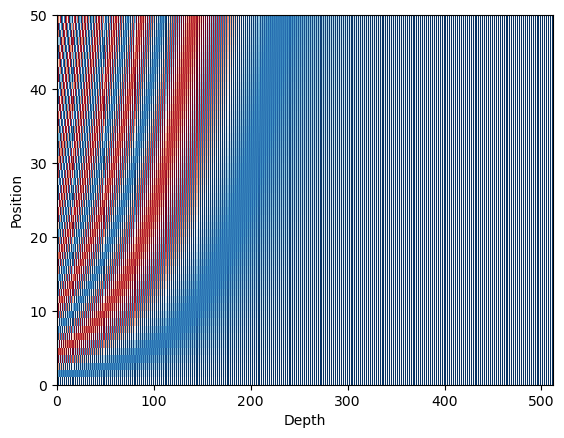

In [253]:
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.show()

In [254]:
# Scaled Dot-Product Attention 메커니즘 구현(query, key, value, mask의 출력 및 어텐션 가중치를 계산)
def scaled_dot_product_attention(q, k, v, mask):
    # 쿼리와 키를 곱한다.(어텐션 스코어 계산), transpose_b : 쿼리와 키의 차원을 곱하기 위해서 맞춰준다.
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    # 스케일링
    dk = tf.cast(tf.shape(k)[-1], tf.float32) # 키 값의 마지막 차원의 크기를 기준으로 스케일링 계수로 사용
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk) # 어텐션 스코어가 매우 큰 값을 가지는 것을 방지하기 위해 스케일링

    if mask is not None: # 마스크 처리
        scaled_attention_logits += (mask * -1e9) # 마스크가 된 위치에 어텐션 스코어를 굉장히 작은 값으로 만들겠다.

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) # softmax 함수를 통해 가중치 계산(마스크 또한 처리)
    output = tf.matmul(attention_weights, v) # 가중치에 value를 곱하여 최종 출력을 구한다.

    return output, attention_weights # 그 두 개의 값을 반환

In [255]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = kargs['num_heads']
        self.d_model = kargs['d_model']

        # d_model이 num_heads로 나누어 떨어지는지?
        # 멀티 헤드 어텐션에서는 d_model을 각각의 헤드로 나누어서 사용한다. ==> d_model이 각 헤드별로 나누어 떨어져야 차원이 균일하게 유지가 된다.
        # 나누어 떨어지지 않으면, 각 헤드의 차원이 서로 달라져서 모델의 성능이 저하될 수 있다.
        # ---> 정확하게 분배해주기 위해 ⭐️
        assert self.d_model % self.num_heads == 0

        # 각 head별로 차원이 몇 개씩 처리될 수 있는지
        self.depth = self.d_model // self.num_heads

        # 3개의 dense layer(q, k, v)
        self.wq = tf.keras.layers.Dense(kargs['d_model']) # 현재 입력에 대한 정보
        self.wk = tf.keras.layers.Dense(kargs['d_model']) # 과거 입력에 대한 정보
        self.wv = tf.keras.layers.Dense(kargs['d_model']) # 출력에 대한 정보

        # 출력 dense layer
        self.dense = tf.keras.layers.Dense(kargs['d_model'])

    # 각 헤드의 입력 차원 분리(병렬 처리)
    def split_heads(self, x, batch_size):
        # x[-1]의(x의 마지막) 차원을 num_heads, depth로 분리한다.
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        # 차원을 (barch_size, num_heads, seq_len, depth)으로 변경한다.
        return tf.transpose(x, perm=[0, 2, 1, 3]) # 입력 데이터의 형태를 맞춘다.

    # 멀티헤드 어텐션 계산
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q) # 입력된 커리 변환
        k = self.wk(k) # 입력된 키 변환
        v = self.wv(v) # 입력된 값 변환

        # 변환된 텐서들을 각각 batch_size만큼 헤드별로 분할
        q = self.split_haeds(q, batch_size) 
        k = self.split_haeds(k, batch_size)
        v = self.split_haeds(v, batch_size)

        # 위에서 제작한 attention 함수를 통해
        # 스케일된 어텐션 값과 어텐션 가중치
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model)) # 스케일링 어텐션값을 다시 세팅

        output = self.dense(concat_attention)

        return output, attention_weights

In [256]:
# 입력 토큰에 대해 독립적으로 토큰별 특징을 추출한다.
def point_wise_feed_forward_network(**kargs):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(kargs['dff'], actication='relu'),
        tf.keras.layers.Dense(kargs['d_model'])
    ])

In [257]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(**kargs)
        self.ffn = point_wise_feed_forward_netword(**kargs)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, mask):
        attn_output, _ = self.mha(x, x, x, mask) # MultiHeadAttention(q, k, v를 x로 사용)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output) # x와 attention의 출력을 더해서 각 특성의 평균과 표준편차로 정규화

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [258]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(**kargs)
        self.mga2 = MultiHeadAttention(**kargs)

        self.ffn = point_wise_feed_forward_netword(**kargs)

        # 정규화
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        # dropout(과적합 방지)
        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout3 = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [259]:
# 세팅이 모두 종료되었음으로, '연결'을 진행한다.
class Encoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(Enoder, self).__init__()

        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']

        self.embedding = tf.keras.layers.Embedding(kargs['input_vocab_size'], self.d_model)
        self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'], self.d_model)

        self.enc_layers = [EncoderLayer(**kargs) for _ in range(self.num_layers)]
        self.dropout = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) # 스케일링
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask)

        return x

In [260]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(Decoder, self).__init__()

        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']

        self.embedding = tf.keras.layers.Embedding(kargs['target_vocab_size'], self.d_model)
        self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'], self.d_model)

        self.dec_layers = [DecoderLayer(**kargs) for _ in range(self.num_layers)]
        self.dropout = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))  # 스케일링
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        return x, attention_weights

In [261]:
# 트랜스포머 모델 설계
class Transformer(tf.keras.Model):
    def __init__(self, **kargs):
        super(Transformer, self).__init__(name=kargs['model_name'])
        self.end_token_idx = kargs['end_token_idx']

        self.encoder = Encoder(**kargs)
        self.decoder = Decoder(**kargs)

        # 최종 출력 layer 생성
        self.final_layer = tf.keras.layers.Dense(kargs['target_vocab_size'])

    def call(self, x):
        input, target = x

        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(input, target)

        # 인코더, 디코더 연결
        enc_output = self.encoder(input, enc_padding_mask)
        dec_output, _ = self.decoder(target, enc_output, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output

    def inference(self, x):
        input = x
        target = tf.expand_dims([SOS_INDEX], 0)

        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(input, target)
        enc_output = self.encoder(input, enc_padding_mask)

        predict_tokens = list()
        for t in range(0, MAX_SEQUENCE):
            dec_output, _ = self.decoder(target, enc_output, look_ahead_mask, dec_padding_mask)
            final_output = self.final_layer(dec_output)
            outputs = tf.argmax(final_output, -1).numpy()
            pred_token = outputs[0][-1] # output[0][-1], 0: 가장 앞에 있는(확률이 높은 값), -1 : Layer의 가장 마지막 
            if pred_token == self.end_token_idx:
                break

            predict_tokens.append(pred_token)
            target = tf.expand_dims([SOS_INDEX] + predict_tokens, 0)
            _, look_ahead_mask, dec_padding_mask = create_masks(input, target)

        return predict_tokens

In [262]:
loss_objects = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

train_accruacy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_objects(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)
    
def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask
    acc = train_accruacy(real, pred)

    return tf.reduce_mean(acc)

In [263]:
model = Transformer(**kargs)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=loss, metrics=[accuracy])

NameError: name 'kargs' is not defined

In [ ]:
checkpoint_path = DATA_OUT_PATH + model_name + '.weight.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

earlystop = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.0001, patience=10)

In [ ]:
history = model.fit(
    [index_inputs, index_outputs], 
    index_targets, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_split=validation_split,
    callbacks=[checkpoint, earlystop]
)

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'_string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [ ]:
plot_graphs(history, 'loss')

In [ ]:
save_file = model_name + '.weights.h5'

model.load_weights(os.path.join(DATA_OUT_PATH, save_file))

In [ ]:
prepro_configs

In [ ]:
char2idx = prepro_configs['char2idx']
idx2char = prepro_configs['idx2char']

In [ ]:
FILTERS = "([~.,!?\"':;)(])"
CHANGE_FILTER = re.compile(FILTERS)

PAD = '<PAD>'
UNK = '<UNK>'

PAD_INDEX = 0
SOS_INDEX = 1

In [ ]:
def enc_processing(value, dictionary, tokenize_as_morph=False):
    sequences_input_index = []
    sequences_length = []

    if tokenize_as_morph:
        value = prepro_like_morphlized(value)

    for sequence in value:
        sequence = re.sub(CHANGE_FILTER, '', sequence)

        sequence_index = []

        for word in sequence.split():
            if dictionary.get(word) is not None:
                sequence_index.extend([dictionary[word]])
            else:
                sequence_index.extend([dictionary[UNK]])

        if len(sequence_index) > max_sequence:
            sequence_index = sequence_index[:MAX_SEQUENCE]

        sequences_length.append(len(sequence_index))
        sequences_index += (max_sequence - len(sequence_index)) * [dictionary[PAD]]

        sequences_input_index.append(sequence_index)

    return np.asarray(sequences_input_index), sequences_length

In [ ]:
MAX_SEQUENCE = 25

text = '안녕하세요. 오늘은 날씨가 참 좋네요.'
test_index_inputs, _ = enc_processing([text], char2idx)
outputs = model.inference(test_index_inputs)

print(outputs)
print(' '.join([idx2char[str(o)] for o in outputs]))